In [144]:
from ce3_compare import set_name, compare, write_submission_txt, grade, set_idm
from feature_model import FeatureModel
import numpy as np

In [145]:
set_name("Moeez", "Mujahid")
set_idm("ty60xupo")

# Computer exercise 3 (Global post-hoc methods)

- Partial dependence plots (PDP)
- Individual conditional expectation (ICE) <- *local*
- M-Plot
- Accumulated local effects (ALE)
- Permutation feature importance

<img src="pdp_ice_mplot_ale.png" width="1200"/>

## Partial dependence plots (PDP)

In [146]:
bike_path = "datasets/bike/rented_bikes_day_pre.csv"
bike_data = FeatureModel(bike_path)
bike_data.df = bike_data.df.drop(labels=["casual", "registered"], axis=1)
bike_data.add_target("cnt")
bike_data.add_all_features_but_target()

FeatureModel(->Not fully specified yet!)
FeatureModel(cnt ~ -1 + season + yr + mnth + holiday + weekday + workingday + weathersit + temp + hum + windspeed + days_since_01_01_2011 )


In [147]:
X,y = bike_data.return_Xy(train_test_split=False)

In [148]:
from sklearn.inspection import PartialDependenceDisplay

def pdp_plot(m, X_train, y_train, X_val=None, kind="average", features=["temp","hum","windspeed"]):
    if X_val is None:
        X_val = X_train
        
    m.fit(X_train, y_train)
    print("R2-score: ", m.score(X_train, y_train))

    pdp = PartialDependenceDisplay.from_estimator(
        m,
        X_val,
        features,
        kind=kind, grid_resolution=100, percentiles=(0,1), method="brute",
        **(dict(pd_line_kw=dict(color="red")) if kind == "both" else {})
    )

    for ax in pdp.axes_[0,:]:
        ax.grid(True)


### PDP for Linear Regression

R2-score:  0.8003086666446174


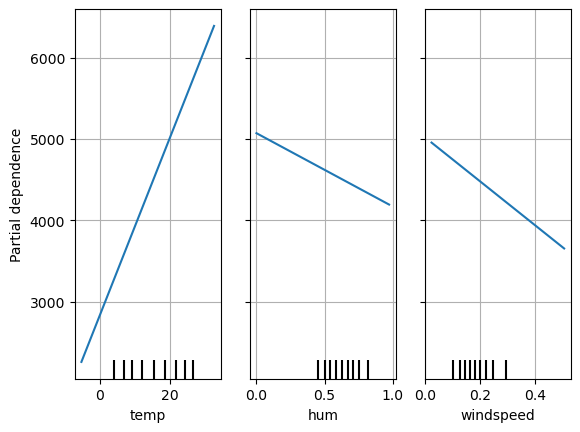

In [149]:
from sklearn.linear_model import LinearRegression

pdp_plot(LinearRegression(), X, y)

Q: What is the meaning of the y-axis in the PDP plot?

Q: What is the meaning of the y-axis for classification?

Q: Does it make sense to create a PDP plot for a LinearRegression?

Q: Does it make sense to create a PDP plot for any inherently explainable model?

### PDP for RandomForestRegressor

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9835492651632314


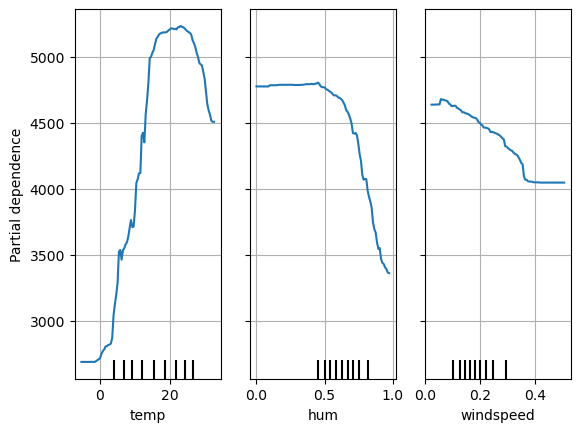

In [150]:
from sklearn.ensemble import RandomForestRegressor

pdp_plot(RandomForestRegressor(), X, y)

### PDP for AdaBoost

/Users/moeezmujahid/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.8531967783409402


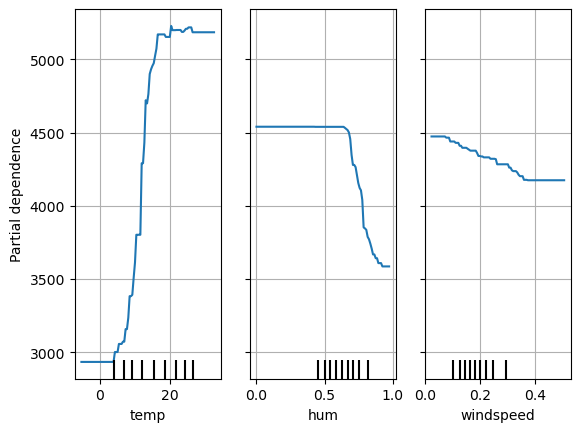

In [151]:
from sklearn.ensemble import AdaBoostRegressor

pdp_plot(AdaBoostRegressor(), X, y)

Q: Does it make sense to use validation data for the averaging?

Q: If you want to explain your model's behaviour, would you use all data / only training data / only validation data?

In [152]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9818969679639621


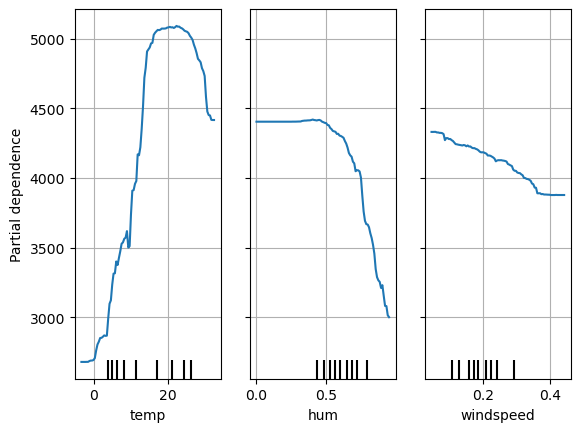

In [153]:
pdp_plot(RandomForestRegressor(), X_train, y_train, X_val)

### Exercise 3.1

Use a `RandomForestRegressor` with `random_state`=1 to predict the number of rented bikes. What is the $\Delta y$ in the last/directly above PDP-plot for the `temp` feature between $20^\circ$ and $0^\circ$? Write a function that returns that exact value.

In [154]:
def ex_3_1() -> float:
    
    rf = RandomForestRegressor(random_state=1)
    rf.fit(X_train, y_train)
    
    X_value = X_val.copy()
    X_value["temp"] = 20
    
    temp_20 = rf.predict(X_value).mean()
    X_value["temp"] = 0
    
    temp_0 = rf.predict(X_value).mean()
    delta_y = temp_20 - temp_0
    return delta_y

In [155]:
ex_3_1()

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/359939505.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


2354.0546938775506

In [156]:
compare("ex_3_1", ex_3_1)

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/359939505.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Great work!


### Exercise 3.2

In the last/directly above PDP-plot for the `windspeed` feature on the x-axis, on which windspeed value is exactly the 5th vertical line? Write a function that returns that exact value.

In [157]:
def ex_3_2() -> float:
    
    val =  X_val['windspeed'].median()
    return val


In [158]:
ex_3_2()

0.185312

In [159]:
compare("ex_3_2", ex_3_2)

There must be at least one second downtime between `compare` calls


### PDP for classification

In [160]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


/Users/moeezmujahid/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.9373177842565598


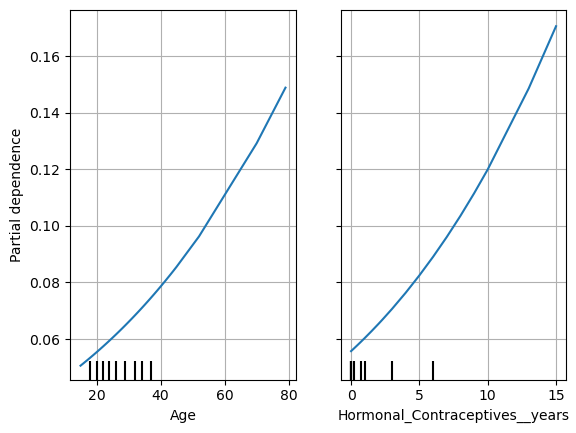

In [161]:
from sklearn.linear_model import LogisticRegression

pdp_plot(LogisticRegression(max_iter=1000), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


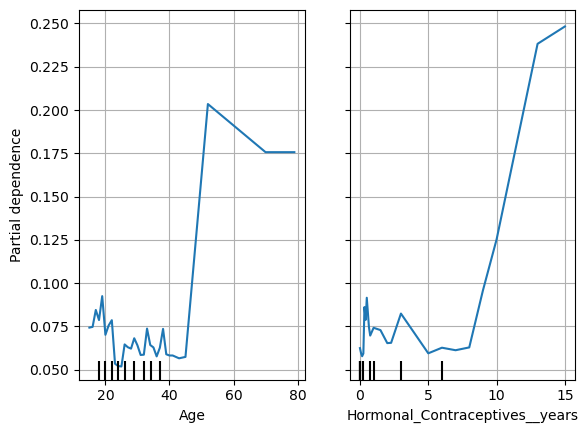

In [162]:
from sklearn.ensemble import RandomForestClassifier
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


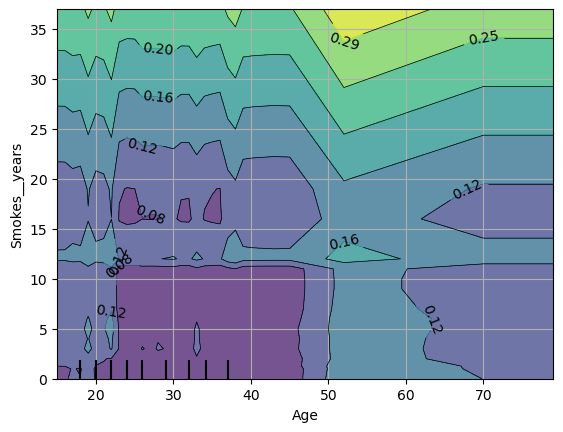

In [163]:
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=[["Age", "Smokes__years"]])

Q: Does this plot imply that smoking increases the cancer probability regardless of age? Take a close look at the upper-left corner

## Individual conditional expectation (ICE) <- local

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


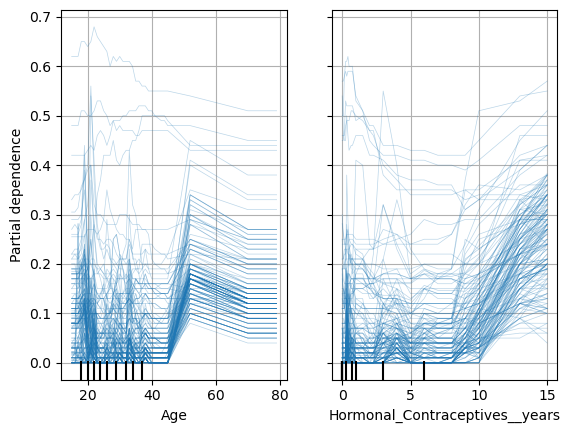

In [164]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="individual")

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/3605117797.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


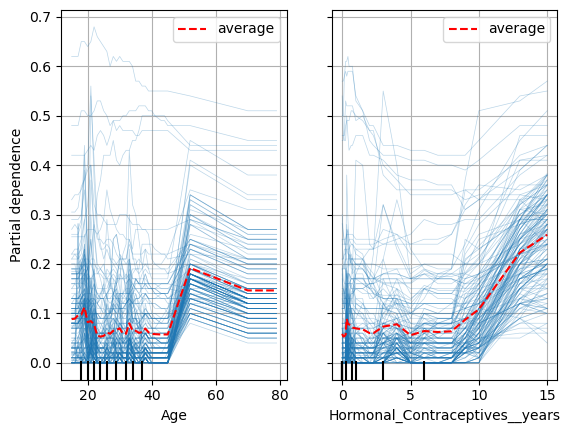

In [165]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="both")

### Exercise 3.3

Use a `RandomForestClassifier(random_state=1)`.
What is the predicted cancer probability with an Age of sixty years according to the datapoint with the highest predicted cancer probability of the validation dataset?
Write a function that returns that value.

In [166]:
def ex_3_3() -> float:
    
    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)
    max_prob_index = model.predict_proba(X_val)
    max_prob_index = max_prob_index[:,1].argmax()
    
    data = X_val.iloc[max_prob_index].copy()
    
    print(data['Age'])
    data['Age'] = 60
    prob = model.predict_proba(data.values.reshape(1, -1))[:, 1][0]

    return prob



In [167]:
ex_3_3()

36.0


/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/2717768460.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users/moeezmujahid/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.52

In [168]:
compare("ex_3_3", ex_3_3)

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/2717768460.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Great work!


/Users/moeezmujahid/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Accumulated local effects (ALE)

In [169]:
from PyALE import ale # <- This really is more of an m-plot

In [170]:
X,y = bike_data.return_Xy()
regr = RandomForestRegressor(random_state=1)
regr.fit(X,y)

/var/folders/sk/fn4_hptd42nbr6_wdcgx06hm0000gn/T/ipykernel_94005/890520154.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X,y)


RandomForestRegressor(random_state=1)

PyALE._ALE_generic:INFO: Continuous feature detected.


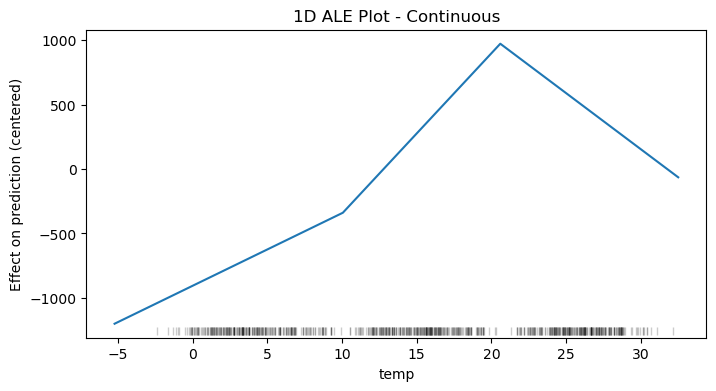

In [171]:
ale_eff = ale(X, regr, ["temp"], grid_size=3, include_CI=False,)

In [172]:
ale_eff

,eff,size
temp,,
-5.220871,-1200.381206,0.0
10.055849,-338.901575,244.0
20.591651,972.902278,244.0
32.498349,-63.894759,243.0


PyALE._ALE_generic:INFO: Continuous feature detected.


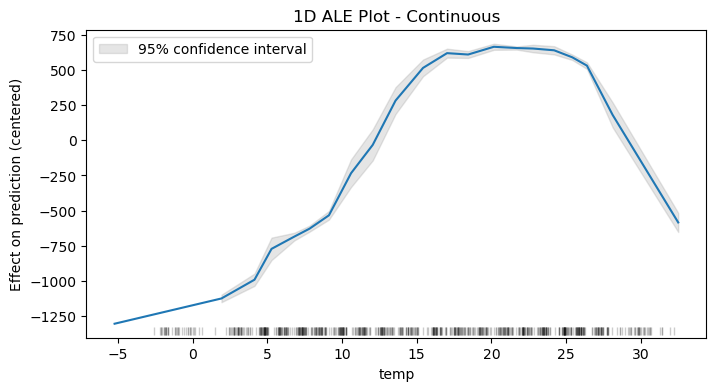

In [173]:
ale_eff = ale(X, regr, ["temp"], grid_size=20, include_CI=True, C=0.95)

In [174]:
ale_eff.reset_index()

,temp,eff,size,lowerCI_95%,upperCI_95%
0,-5.220871,-1304.437601,0.0,NaN,NaN
1,1.931288,-1124.719223,37.0,-1151.469293,-1097.969152
2,4.141651,-991.390612,36.0,-1035.050161,-947.731062
3,5.282623,-771.891422,37.0,-851.772184,-692.010661
4,6.805000,-684.808922,36.0,-712.302558,-657.315286
5,7.823349,-628.386760,37.0,-649.767757,-607.005763
6,9.124356,-533.140371,36.0,-563.883810,-502.396933
7,10.604151,-233.696858,37.0,-332.230836,-135.162880
8,12.053349,-32.454636,36.0,-143.061396,78.152125
9,13.580849,282.745635,37.0,187.392936,378.098333


### Exercise 3.4

For what *lower* temperature is the expectation of the centered effect on the predicted number of rented bikes exactly zero?
(You may use the table directly above)

In [175]:
 from sklearn.linear_model import LinearRegression

In [176]:
def ex_3_4() -> float:

    ale = ale_eff.reset_index()
    closest_to_zero_index = (ale['eff'].abs()).idxmin()
    closest_to_zero_index_range = closest_to_zero_index + 1
    
    
    x_train= [ale['eff'][closest_to_zero_index], ale['eff'][closest_to_zero_index_range]]
    y_train = [ale['temp'][closest_to_zero_index], ale['temp'][closest_to_zero_index_range]]

    
    x_train = np.reshape(x_train, (-1,1))
    y_train = np.reshape(y_train, (-1,1))

    
    regL = LinearRegression().fit(x_train, y_train)
    output = regL.predict([[0.0]])
    
    
    

    return output[0][0]


In [177]:
ex_3_4()

12.210628229981651

In [178]:
compare("ex_3_4", ex_3_4)

There must be at least one second downtime between `compare` calls


### Exercise 3.5 (harder)

Using the above table, what is the 95%-confidence interval of the effect delta when going from `temp=1.931288` to `temp=4.141651`?

*Hint 1*: The 95%-confidence intervall for a normal distribution is at $1.96$ standard deviations

*Hint 2*: https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables

In [179]:
def ex_3_5() -> (float, float):
    
    
    effect_delta = abs(-1124.719223 - (-991.390612))
    variance_1 = ((-1097.969152 - (-1151.469293)) / (2 * 1.96)) ** 2
    variance_2 = ((-947.731062 - (-1035.050161)) / (2 * 1.96)) ** 2
    standard_deviation = (variance_1 + variance_2) ** 0.5
    lower_bound = effect_delta - 1.96 * standard_deviation
    upper_bound = effect_delta + 1.96 * standard_deviation
    return (lower_bound , upper_bound)


In [180]:
ex_3_5()

(82.12585195033628, 184.53137004966376)

In [181]:
compare("ex_3_5", ex_3_5)

There must be at least one second downtime between `compare` calls


## Permutation feature importance

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but *how important this feature is for a particular model*.


In [182]:
from sklearn.inspection import permutation_importance

In [183]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

In [184]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, y_train)
regr.score(X_val, y_val)

/Users/moeezmujahid/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9021025738192169

In [185]:
r = permutation_importance(regr, X_val, y_val, n_repeats=20, random_state=1)

In [186]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<22} | "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

days_since_01_01_2011  | 0.711 +/- 0.047
temp                   | 0.459 +/- 0.034
hum                    | 0.050 +/- 0.010
windspeed              | 0.030 +/- 0.009
weathersit             | 0.016 +/- 0.007
season                 | 0.011 +/- 0.004
mnth                   | 0.008 +/- 0.003
workingday             | 0.007 +/- 0.002


### Exercise 3.6

Using a `GradientBoostingClassifier(random_state=1)` and `permutation_importance(..., n_repeats=20, random_state=1)`. What is the most important feature of in the cervical cancer dataset?
Write a function that returns this column name.

In [187]:
def ex_3_6() -> str:
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import RandomForestClassifier
    cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
    cancer_data = FeatureModel(cancer_path)
    cancer_data.add_target("Biopsy")
    cancer_data.add_all_features_but_target()
    X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)
    model = GradientBoostingClassifier(random_state=1)
    model.fit(X_train, y_train)
    
    perm_importance = permutation_importance(model, X_val, y_val, n_repeats=20, random_state=1)
    feature_importance = perm_importance.importances_mean
    print(feature_importance)
    most_important_index = np.argmax(feature_importance)
    most_important_feature = X_train.columns[most_important_index]
    
    return most_important_feature

In [188]:
ex_3_6()

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


/Users/moeezmujahid/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-0.00523256 -0.01569767  0.00348837 -0.00494186  0.         -0.01075581
 -0.00436047 -0.00523256  0.          0.00087209  0.         -0.01017442
 -0.0002907  -0.0005814 ]


'First_sexual_intercourse'

In [189]:
compare("ex_3_6", ex_3_6)

/Users/moeezmujahid/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Great work!


Q: Argue why you might question this result?

Q: Repeat `ex_3_6` with a `RandomForestClassifier` instead. What is now the result?

In [190]:
from ce3_compare import scores

In [191]:
scores

{'ex_3_1': True,
 'ex_3_2': True,
 'ex_3_3': True,
 'ex_3_4': True,
 'ex_3_6': True,
 'ex_3_5': True}

In [192]:
write_submission_txt()

In [193]:
grade("ce3_Moeez_Mujahid.txt")

'100.0% are correct'